### Overview

The AMBRS tools facilitate intercoparison of aerosol box models. The core coponents include (1) the CMake-based AMBuilder for consistent model building, (2) the Python-based AMBRS driver for automated generation of unified numerical experiments, and (3) the Python-based PyParticle package for standardization of model output and downstream analysis.

This notebook describes the steps to build, run, and analyze the AMBRS models.

### Step 1: Build supported models via AMBuilder

Build all box models via [AMbuilder](https://github.com/AMBRS-project/ambuilder)

Install additional AMBRS dependencies via:
```
pip install -r requirements.txt
```

### Step 2: Run comparible simulation experiments with the AMBRS driver  

In [1]:
# -----------------------------------------------------------
# Import modules
# -----------------------------------------------------------
import os
import logging
from math import log10
from pathlib import Path

import numpy as np
import scipy.stats as stats

import ambrs
from pathlib import Path

# -----------------------------------------------------------
# Configure simualtions
# -----------------------------------------------------------

n = 5        # number of ensemble members
n_part = 5000  # PartMC particles per run

dt = 60      # timestep [s]
nstep = 60   # 60 min run

p0 = 101325  # reference pressure [Pa]
h0 = 500     # reference height [m]

# -----------------------------------------------------------
# Make directories for simulation output
# -----------------------------------------------------------
ensemble_name = str(int(dt*nstep/60)) + "min_" + str(n) + "particles"
repo_root = Path.cwd().resolve()
root_dir =  repo_root / "runs" 
ensemble_dir =  root_dir / ensemble_name
partmc_dir = os.path.join(ensemble_dir, "partmc_runs")
mam4_dir = os.path.join(ensemble_dir, "mam4_runs")

for d in [root_dir, ensemble_dir, partmc_dir, mam4_dir]:
    os.makedirs(d, exist_ok=True)


# -----------------------------------------------------------
# Define species
# -----------------------------------------------------------
so4 = ambrs.AerosolSpecies("SO4", molar_mass=96., density=1800., hygroscopicity=0.65)
pom = ambrs.AerosolSpecies("OC", molar_mass=12.01, density=1000., hygroscopicity=0.001)
soa = ambrs.AerosolSpecies("MSA", molar_mass=40., density=2600., hygroscopicity=0.53)
bc  = ambrs.AerosolSpecies("BC",  molar_mass=12.01, density=1800., hygroscopicity=0.)
dst = ambrs.AerosolSpecies("OIN", molar_mass=135.065, density=2600., hygroscopicity=0.1)
na  = ambrs.AerosolSpecies("Na",  molar_mass=23., density=2200., hygroscopicity=0.53)
cl  = ambrs.AerosolSpecies("Cl",  molar_mass=35.5, density=2200., hygroscopicity=0.53)
ncl = na
h2o = ambrs.AerosolSpecies("H2O", molar_mass=18., density=1000., ions_in_soln=1)

so2   = ambrs.GasSpecies("SO2", molar_mass=64.07)
h2so4 = ambrs.GasSpecies("H2SO4", molar_mass=98.079)

# -----------------------------------------------------------
# Define aerosol processes
# -----------------------------------------------------------
processes = ambrs.AerosolProcesses(
    coagulation=True,
    condensation=True,
)

# -----------------------------------------------------------
# Ensemble specification
# -----------------------------------------------------------
spec = ambrs.EnsembleSpecification(
    name=ensemble_name,
    aerosols=(so4, pom, soa, bc, dst, ncl, h2o),
    gases=(so2, h2so4),
    size=ambrs.AerosolModalSizeDistribution(modes=[
        ambrs.AerosolModeDistribution(
            name="accumulation",
            species=[so4, pom, soa, bc, dst, ncl],
            number=stats.uniform(1e7, 1e10),
            geom_mean_diam=stats.rv_discrete(values=([1.1e-7], [1.])),
            log10_geom_std_dev=log10(1.6),
            mass_fractions=[
                stats.rv_discrete(values=([1.], [1.])),  # SO4
                stats.rv_discrete(values=([0.], [1.])),  # POM
                stats.rv_discrete(values=([0.], [1.])),  # SOA
                stats.rv_discrete(values=([0.], [1.])),  # BC
                stats.rv_discrete(values=([0.], [1.])),  # DST
                stats.rv_discrete(values=([0.], [1.])),  # NCL
            ],
        ),
        ambrs.AerosolModeDistribution(
            name="aitken",
            species=[so4, soa, ncl],
            number=stats.uniform(1e7, 1e11),
            geom_mean_diam=stats.rv_discrete(values=([2.6e-8], [1.])),
            log10_geom_std_dev=log10(1.6),
            mass_fractions=[
                stats.rv_discrete(values=([1.], [1.])),  # SO4
                stats.rv_discrete(values=([0.], [1.])),  # SOA
                stats.rv_discrete(values=([0.], [1.])),  # NCL
            ],
        ),
        ambrs.AerosolModeDistribution(
            name="coarse",
            species=[dst, ncl, so4, bc, pom, soa],
            number=stats.uniform(1e6, 1e7),
            geom_mean_diam=stats.rv_discrete(values=([2e-6], [1.])),
            log10_geom_std_dev=log10(1.8),
            mass_fractions=[
                stats.rv_discrete(values=([0.], [1.])),
                stats.rv_discrete(values=([0.], [1.])),
                stats.rv_discrete(values=([1.], [1.])),  # SO4
                stats.rv_discrete(values=([0.], [1.])),
                stats.rv_discrete(values=([0.], [1.])),
                stats.rv_discrete(values=([0.], [1.])),
            ],
        ),
        ambrs.AerosolModeDistribution(
            name="primary carbon",
            species=[pom, bc],
            number=stats.rv_discrete(values=([0.], [1.])),
            geom_mean_diam=stats.loguniform(1e-8, 5e-8),
            log10_geom_std_dev=log10(1.8),
            mass_fractions=[
                stats.rv_discrete(values=([1.], [1.])),  # POM
                stats.rv_discrete(values=([0.], [1.])),  # BC
            ],
        ),
    ]),
    gas_concs=tuple([stats.uniform(1e-10, 1e-8) for _ in range(2)]),
    flux=stats.uniform(1e-11, 1e-8),
    relative_humidity=stats.uniform(0, 0.99),
    temperature=stats.uniform(240, 310),
    pressure=p0,
    height=h0,
)

# -----------------------------------------------------------
# Create ensemble
# -----------------------------------------------------------
ensemble = ambrs.lhs(specification=spec, n=n)
scenario_names = [str(ii).zfill(1) for ii in range(1, len(ensemble.flux))]

# -----------------------------------------------------------
# Run MAM4
# -----------------------------------------------------------
mam4 = ambrs.mam4.AerosolModel(processes=processes)
mam4_inputs = mam4.create_inputs(ensemble=ensemble, dt=dt, nstep=nstep)
mam4_runner = ambrs.PoolRunner(
    model=mam4,
    executable="mam4",
    root=mam4_dir,
    num_processes=1,
)
mam4_runner.run(mam4_inputs)

# -----------------------------------------------------------
# Run PartMC
# -----------------------------------------------------------
partmc = ambrs.partmc.AerosolModel(
    processes=processes,
    run_type="particle",
    n_part=n_part,
    n_repeat=1,
)
partmc_inputs = partmc.create_inputs(ensemble=ensemble, dt=dt, nstep=nstep)
partmc_runner = ambrs.PoolRunner(
    model=partmc,
    executable="partmc",
    root=partmc_dir,
    num_processes=1,
)
partmc_runner.run(partmc_inputs)


mam4: one or more existing scenario directories found. Overwriting contents...
partmc: one or more existing scenario directories found. Overwriting contents...


### Step 3: Analyze and vizualize model output with PyParticle    

/Users/fier887/Library/CloudStorage/OneDrive-PNNL/Code/PyParticle/src/PyParticle/aerosol_particle.py:262: UserWarning: Surface tension not implemented; returning default 0.072 N/m
  warnings.warn("Surface tension not implemented; returning default 0.072 N/m", UserWarning)


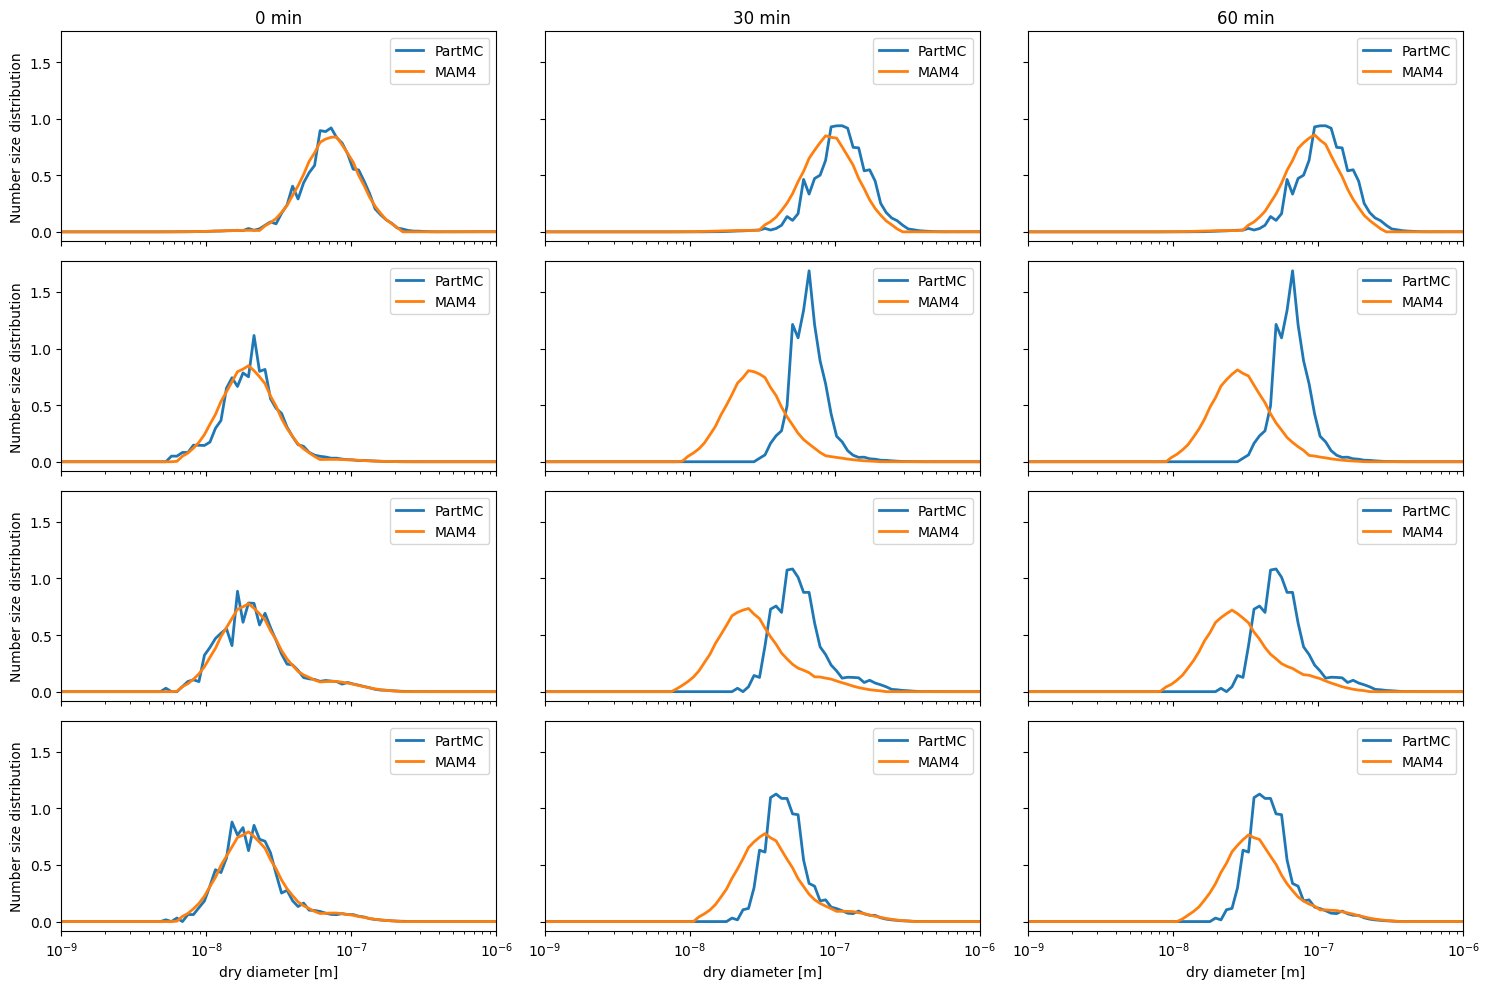

In [2]:
import matplotlib.pyplot as plt

from PyParticle.viz.style import StyleManager, Theme
from PyParticle.viz.builder import build_plotter
import matplotlib.pyplot as plt
import numpy as np

timesteps = [1, 31, 61]
scenarios = scenario_names

fig,ax = plt.subplots(len(scenarios), len(timesteps), figsize=(15,10), squeeze=False, sharex=True, sharey=True)
for i, scenario_name in enumerate(scenarios):
    for j, timestep_to_plot in enumerate(timesteps):
        partmc_output = ambrs.partmc.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=ensemble.member(int(scenario_name) - 1),
            timestep=timestep_to_plot,
            repeat_num=1,
            species_modifications={},
            ensemble_output_dir=partmc_dir,
        )
        mam4_output = ambrs.mam4.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=ensemble.member(int(scenario_name) - 1),
            timestep=timestep_to_plot,
            repeat_num=1,
            species_modifications={},
            ensemble_output_dir=mam4_dir,
        )

        # -----------------------------------------------------------
        # Standardized outputs are used for downstream analysis and visualization
        # -----------------------------------------------------------

        mgr = StyleManager(Theme(), deterministic=False)

        # Lines
        series = [
            {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
            {"key": "mam4", "population": mam4_output.particle_population, "label": "MAM4"},
        ]

        # Build line styles after series is known
        line_styles = mgr.plan("line", [s["key"] for s in series])

        for s in series:
            cfg = {
                "varname": "dNdlnD",
                "var_cfg": {"D": np.logspace(-9, -5, 40),'normalize': True},
                "style": line_styles[s["key"]],
            }
            plotter = build_plotter("state_line", cfg)
            plotter.plot(s["population"], ax[i,j], label=s["label"])
        ax[i,j].set_xscale('log'); 
        ax[i,j].legend(); 
        if i == 0:
            ax[i,j].set_title(f'{timestep_to_plot-1} min')
        if j > 0:
            ax[i,j].set_ylabel('')
        if i < len(scenarios) - 1:
            ax[i,j].set_xlabel('')
        fig.tight_layout()

/Users/fier887/Library/CloudStorage/OneDrive-PNNL/Code/PyParticle/src/PyParticle/analysis/population/factory/frac_ccn.py:37: UserWarning: Both 's_grid' and 's_eval' provided with different lengths (50 vs 100). Using 's_grid'.
  warnings.warn(


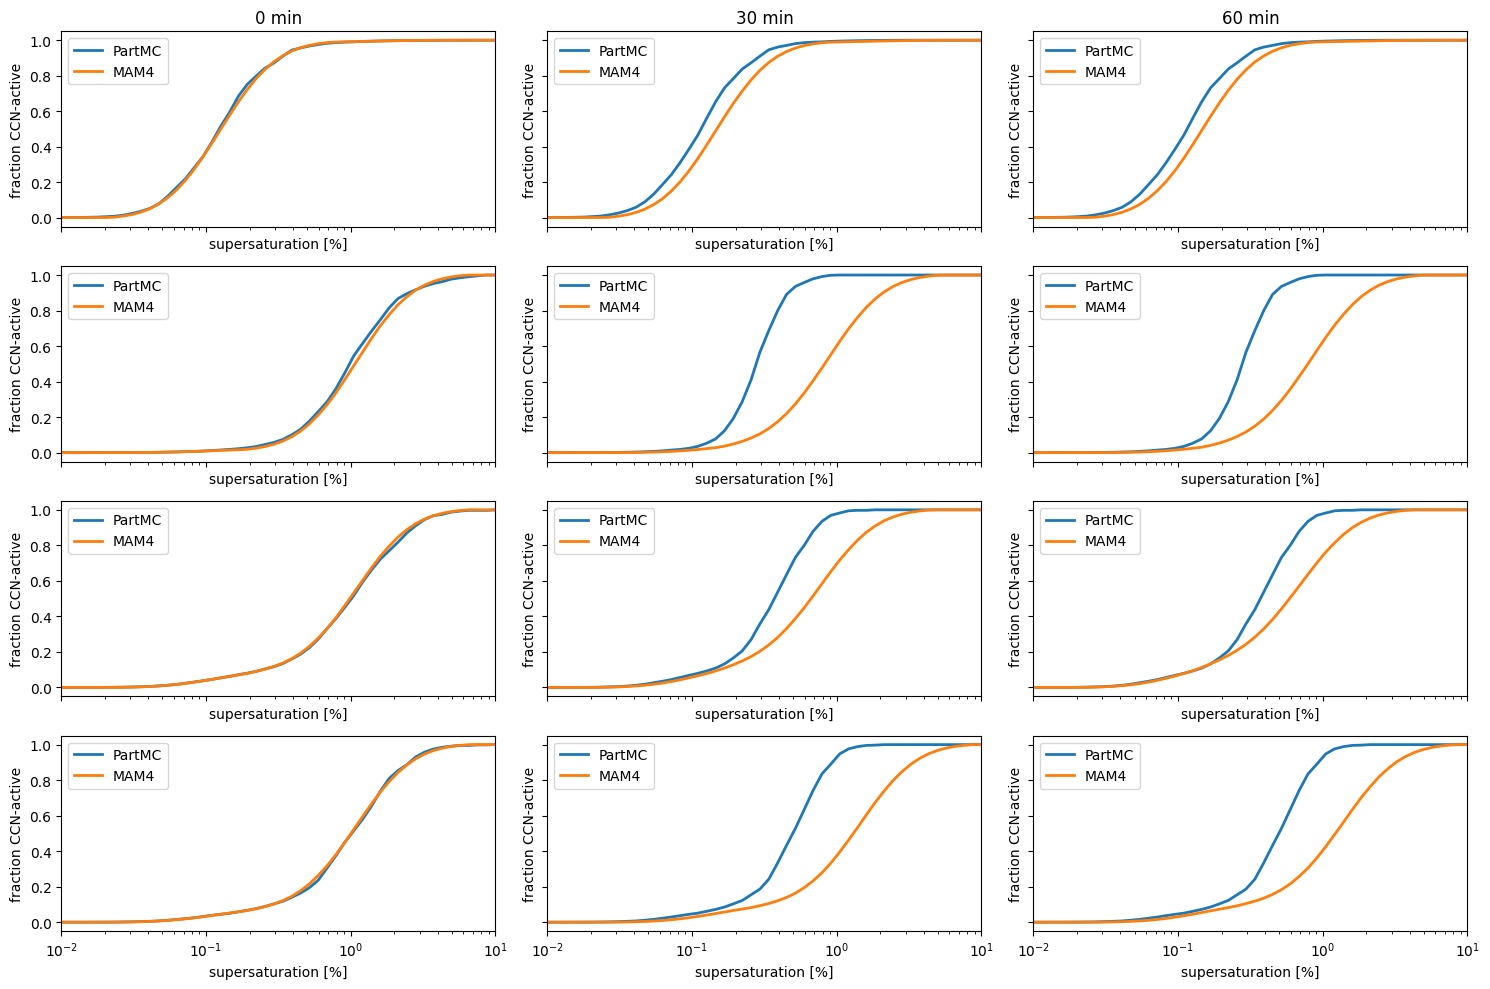

In [3]:
fig,ax = plt.subplots(len(scenarios), len(timesteps), figsize=(15,10), squeeze=False, sharex=True, sharey=True)
for i, scenario_name in enumerate(scenarios):
    for j, timestep_to_plot in enumerate(timesteps):
        partmc_output = ambrs.partmc.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=ensemble.member(int(scenario_name) - 1),
            timestep=timestep_to_plot,
            repeat_num=1,
            species_modifications={},
            ensemble_output_dir=partmc_dir,
        )
        mam4_output = ambrs.mam4.retrieve_model_state(
            scenario_name=scenario_name,
            scenario=ensemble.member(int(scenario_name) - 1),
            timestep=timestep_to_plot,
            repeat_num=1,
            species_modifications={},
            ensemble_output_dir=mam4_dir,
        )

        # -----------------------------------------------------------
        # Standardized outputs are used for downstream analysis and visualization
        # -----------------------------------------------------------
        mgr = StyleManager(Theme(), deterministic=False)

        # Lines
        series = [
            {"key": "partmc", "population": partmc_output.particle_population, "label": "PartMC"},
            {"key": "mam4", "population": mam4_output.particle_population, "label": "MAM4"},
        ]

        # Build line styles after series is known
        line_styles = mgr.plan("line", [s["key"] for s in series])

        for s in series:
            cfg = {
                "varname": "frac_ccn",
                "var_cfg": {"s_grid": np.logspace(-2, 1., 50)},
                "style": line_styles[s["key"]],
            }
            plotter = build_plotter("state_line", cfg)
            plotter.plot(s["population"], ax[i,j], label=s["label"])
        ax[i,j].set_xscale('log'); 
        ax[i,j].legend(); 
        if i == 0:
            ax[i,j].set_title(f'{timestep_to_plot-1} min')
        fig.tight_layout()